# Si

In [ ]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd


In [ ]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gasolina superior"]]


In [3]:
train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data


,Fecha,Gasolina superior,Año,Mes
0,2000-01-01,308156.82,2000,1
1,2000-02-01,307766.31,2000,2
2,2000-03-01,331910.29,2000,3
3,2000-04-01,315648.08,2000,4
4,2000-05-01,319667.97,2000,5
...,...,...,...,...
271,2022-08-01,581844.42,2022,8
272,2022-09-01,570632.20,2022,9
273,2022-10-01,573943.48,2022,10
274,2022-11-01,572163.23,2022,11


# Consumo de Gasolina

In [4]:
train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

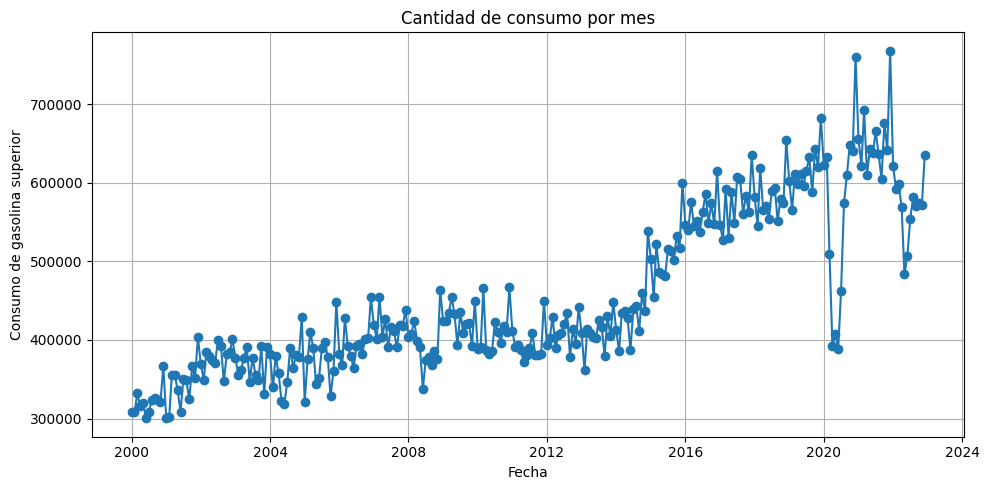

In [40]:

# Graficar solo la columna de consumo
plt.figure(figsize=(10, 5))
plt.plot(train_data["Gasolina superior"], marker='o')

plt.title("Cantidad de consumo por mes")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.grid(True)
plt.tight_layout()
plt.show()


Existe una tendencia creciente en la grafica con un caida muy abrupta a inicio del año 2020 posiblemente ocasionada por el inicio de la pandemia. Se puede ver levemenete como exisen picos cada ciertos puntos que son mas altos que los demas esto posiblemente puede ser que exista algun tipo de estacionalidad y a medida que avanza la grafica se ve como la varianza es creciente y no siempre es igual.

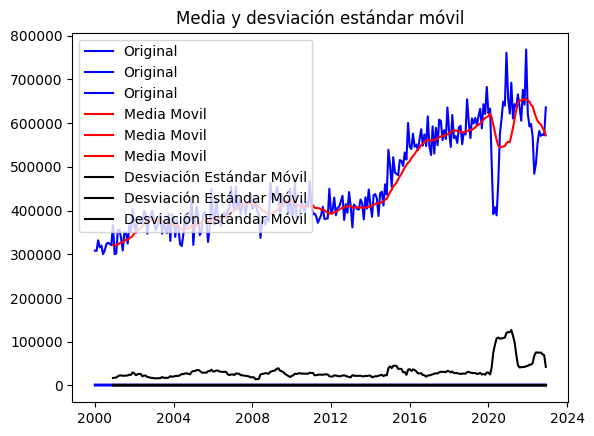

In [6]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = train_data.rolling(window=12).mean()
deMovil = train_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(train_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Se puede evidenciar una tendecia creciente en cuanto a el consumo de gasolina super, evitando el año 2020 el cual es un dato bastante atipoco para el modelo. la desviacion estandar es bastante constante hasta el año 2020 el cual hay un salto abrupto en cuando a la varianza.

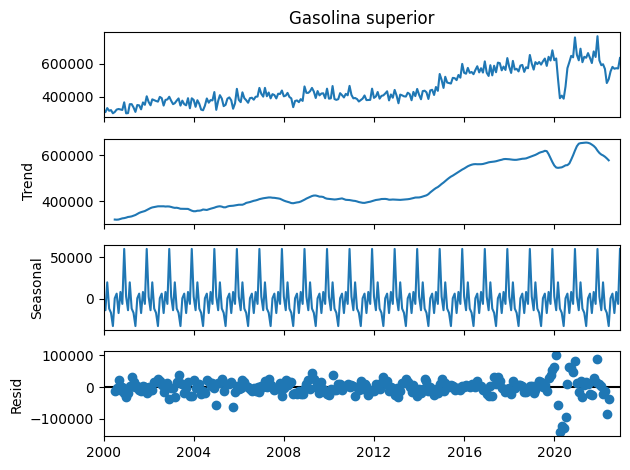

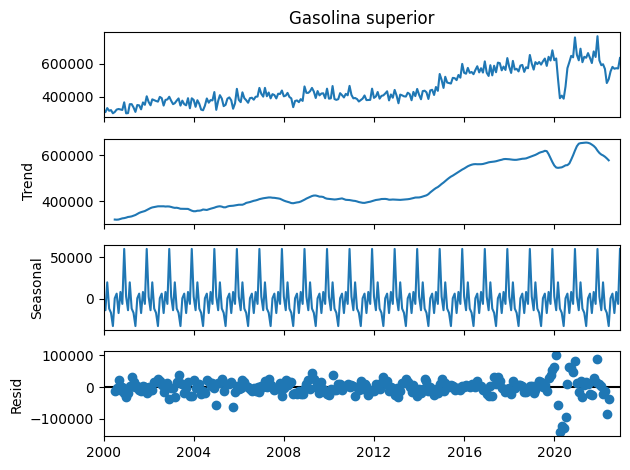

In [7]:
descomposicion = seasonal_decompose(train_data["Gasolina superior"])
descomposicion.plot()

Se puede ver cierta tendencia creciente no constante, se puede ver estacionalidad clara que se repite todos los meses. Los residuos parecen ser constante hasta 2020 donde se comportan de manera aleatoria. Con todo esto se puede afirmar que la grafica es no es estacionaria en media y solo por el año 2020 se comporta no estacionaria en varianza.

In [42]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gasolina superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.268840
p-value                        0.643305
# de retardos usados          12.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


Se puede observar como el valor de p es bastante alto mayor a 0.05 por lo tanto la hipotesis nula no es estacionaria en media. Aplicamos diferenciacion y logaritmo para ver si alguna hace que se vuelva estacionaria

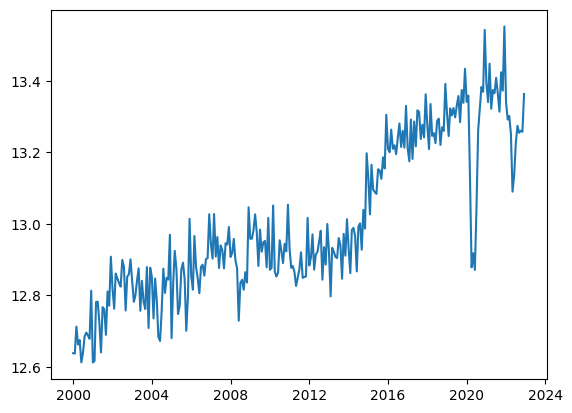

In [8]:
ts_air_pas_log = np.log(train_data["Gasolina superior"])
plt.plot(ts_air_pas_log)

In [41]:

# Aplicar logaritmo
ts_log = np.log(train_data["Gasolina superior"])

# Hacer el test ADF sobre la serie logarítmica directamente
adf_log = adfuller(ts_log.dropna())
print("ADF - Logarítmica")
print(pd.Series(adf_log[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas']))


ADF - Logarítmica
Estadístico de prueba         -1.399617
p-value                        0.582460
# de retardos usados          12.000000
# de observaciones usadas    263.000000
dtype: float64


Se puede observar como el logaritmo no ayudo. Por lo tanto sigue siendo no estacionaria en media

El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [10]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gasolina superior"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -5.787650e+00
p-value                      4.956215e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.630000e+02
Critical Value (1%)         -3.455461e+00
Critical Value (5%)         -2.872593e+00
Critical Value (10%)        -2.572660e+00
dtype: float64


Al ser un valor mas pequeño de 0.05 se puede afierar que se rechaza la hipotesis nula, la serie diferenciada es tacionaria en media

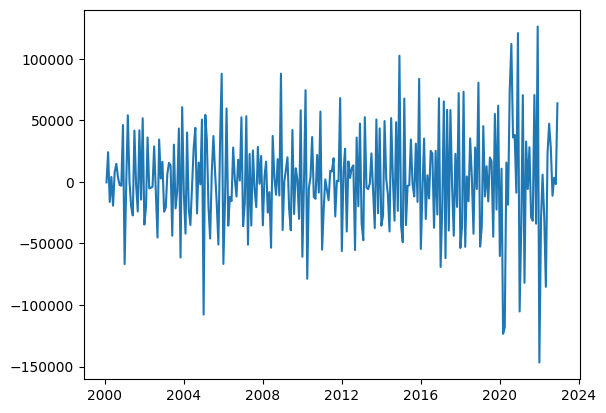

In [11]:
plt.plot(ts_air_pas_diff)

Se puede observar como la seria ahora parace mas estacionaria en media unicamente por los valores del año 2020


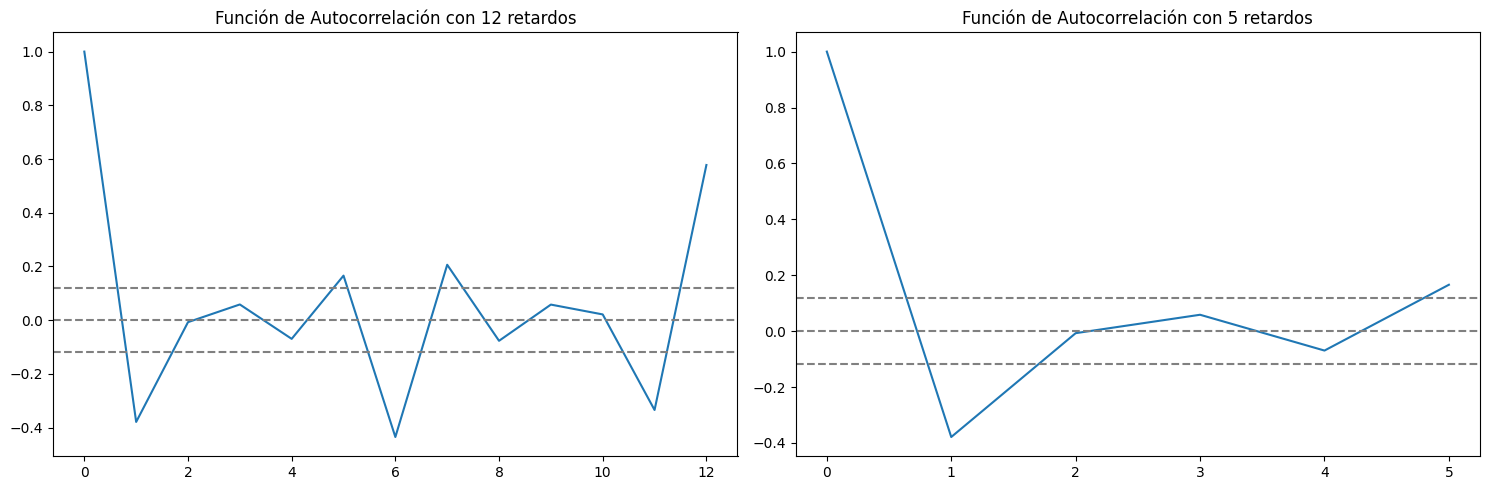

In [12]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_air_pas_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_air_pas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

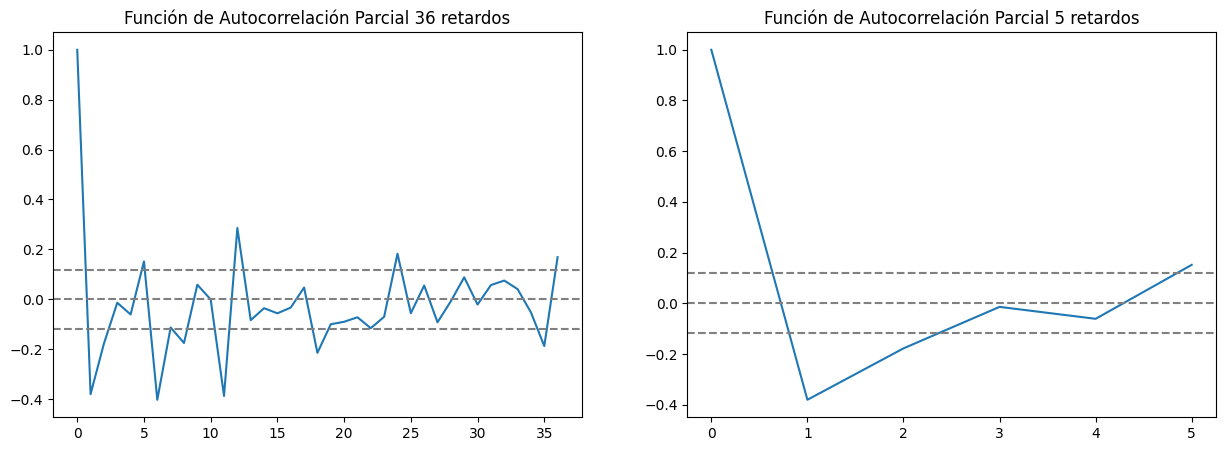

In [13]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_air_pas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_air_pas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA.
Podíamos probar varios modelos ARIMA:
- p=1, q=1
- p=1, q=0
  
En ambos casos solo es necesaria una diferenciación por lo que d=1

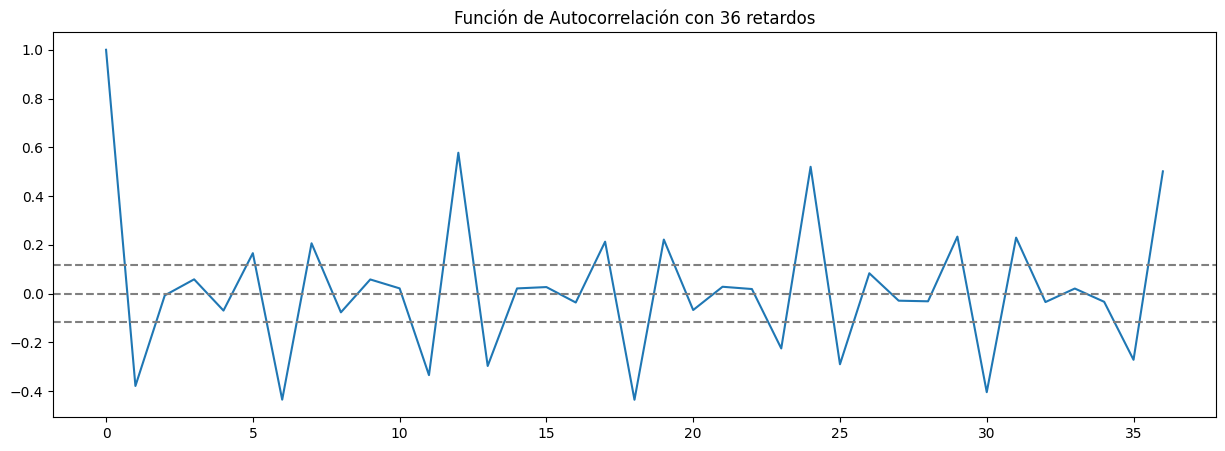

In [14]:
plt.plot(acf(ts_air_pas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar para 12, 24, 36 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Deberíamos agregarle el componente estacional

In [15]:
ts_air_pas_diff_D = ts_air_pas_diff.diff(12)
ts_air_pas_diff_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

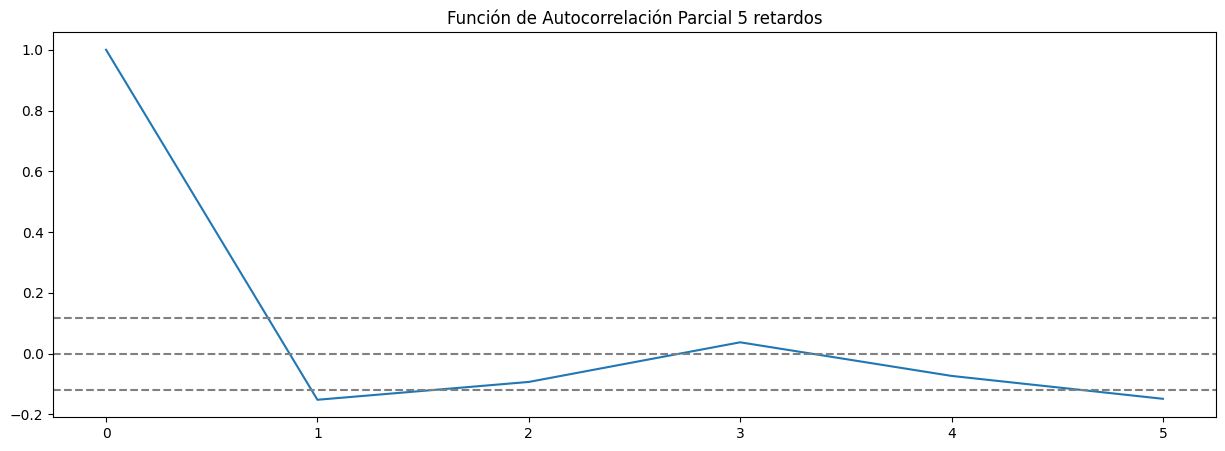

In [16]:
plt.plot(pacf(ts_air_pas_diff_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=2. Probemos el siguiente componente estacional:
- P = 1
- D = 1
- Q = 1

In [17]:
modelo_sarima = SARIMAX(
    ts_air_pas_diff,
    order=(1, 1, 1),                 # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 12),    # SARIMA(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_sarima.fit()

print(resultado_sarima.summary().tables[1])

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2049      0.069     -2.949      0.003      -0.341      -0.069
ma.L1         -0.9891      0.057    -17.255      0.000      -1.101      -0.877
ar.S.L12      -0.1133      0.181     -0.626      0.531      -0.468       0.241
ma.S.L12      -0.7412      0.131     -5.659      0.000      -0.998      -0.484
sigma2      1.763e+09   5.58e-11   3.16e+19      0.000    1.76e+09    1.76e+09


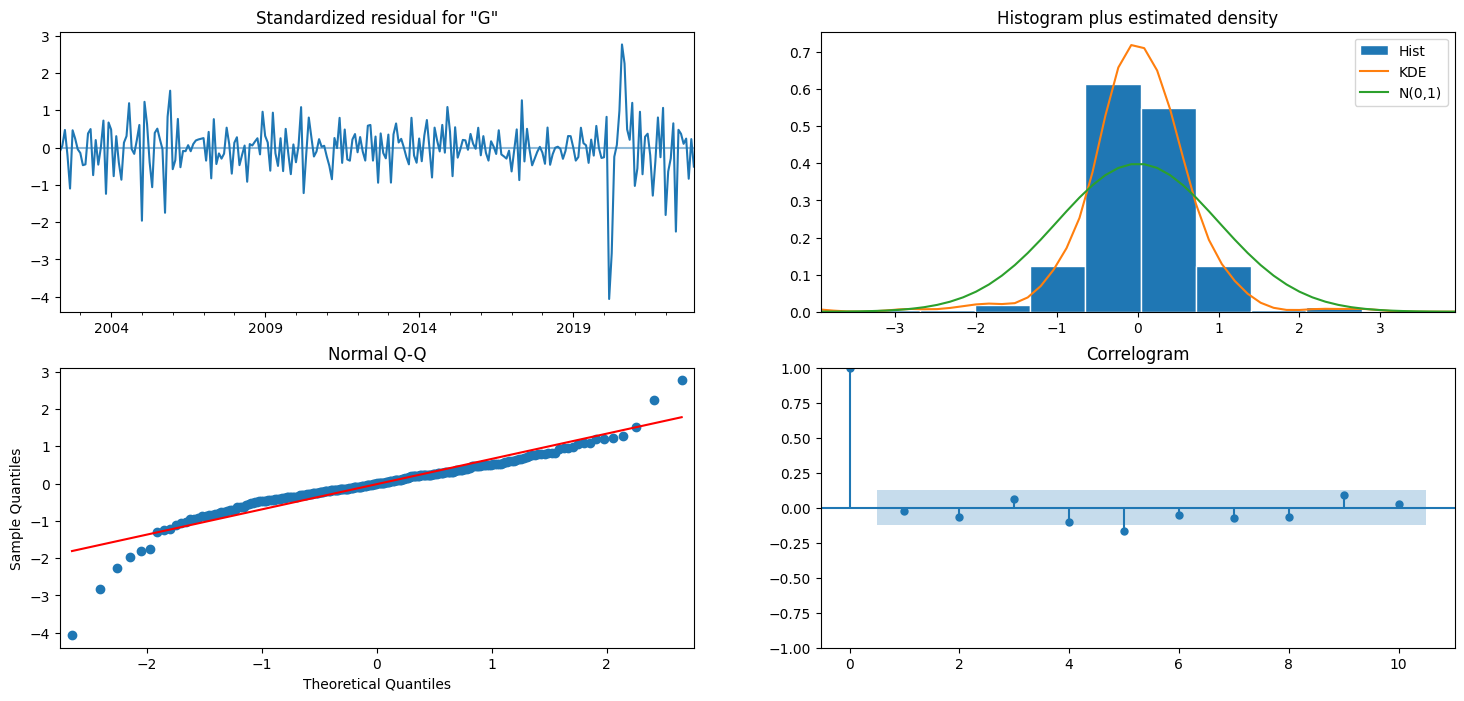

In [18]:
resultado_sarima.plot_diagnostics(figsize=(18, 8))
plt.show()

In [51]:
modelo_2 = SARIMAX(
    ts_air_pas_diff,
    order=(2, 1, 0),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_2 = modelo_2.fit()
print("Modelo SARIMA(2,1,0)(1,1,1,12)")
print(resultado_2.summary().tables[1])

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMA(2,1,0)(1,1,1,12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8276      0.063    -13.038      0.000      -0.952      -0.703
ar.L2         -0.4522      0.071     -6.369      0.000      -0.591      -0.313
ar.S.L12      -0.1324      0.133     -0.998      0.318      -0.393       0.128
ma.S.L12      -0.7418      0.086     -8.642      0.000      -0.910      -0.574
sigma2      1.801e+09   3.44e-11   5.23e+19      0.000     1.8e+09     1.8e+09


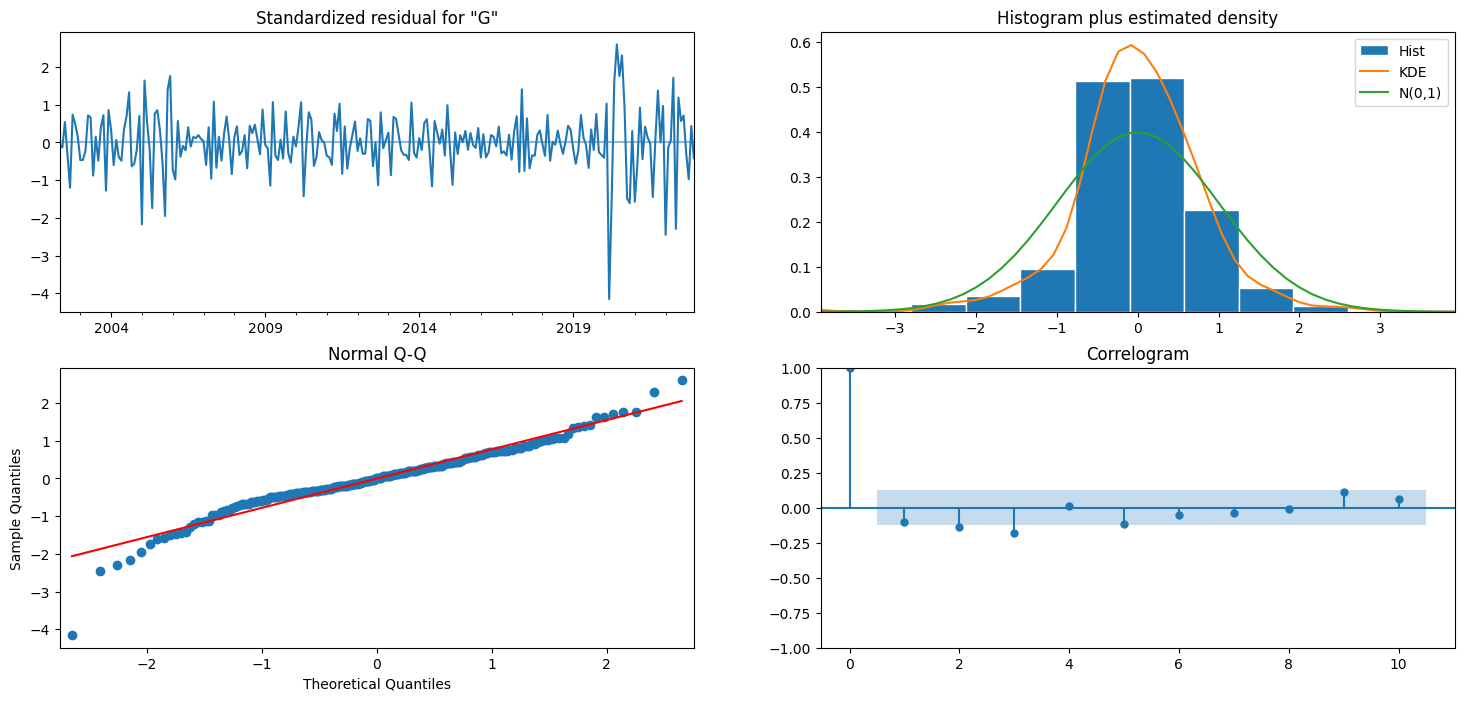

In [52]:
resultado_2.plot_diagnostics(figsize=(18, 8))
plt.show()

In [53]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1=",resultado_sarima.aic)
print("Modelo 2=",resultado_2.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1=",resultado_sarima.bic)
print("Modelo 2=",resultado_2.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1= 5861.609942678226
Modelo 2= 5900.663030151794
Resultados de BIC (Bayesian information criterion)
Modelo 1= 5879.17708640905
Modelo 2= 5918.230173882619


En ambos modelos, la mayoría de los residuos no muestran autocorrelación significativa y se puede observar como ambos modelos son basatnte malos pero el mejor de los seria el primero modelo

In [54]:
hoja_df_2025 = pd.read_excel("./data/VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gasolina superior"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)

In [55]:
test_data.index[0]

Timestamp('2023-01-01 00:00:00')

In [57]:
# Obtener predicciones desde el modelo
pred = resultado_sarima.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_diff = pred.predicted_mean

# Reconstruir valores originales sumando las diferencias al último valor conocido del train
last_train_value = train_data["Gasolina superior"].iloc[-1]
predicted_real = pred_diff.cumsum() + last_train_value


In [58]:
comparison_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Predicción (SARIMA)": predicted_real
})


In [59]:
comparison_df

,Real,Predicción (SARIMA)
2023-01-01,599501.29,561208.378998
2023-02-01,544144.00,536335.019092
2023-03-01,656941.64,556585.387968
2023-04-01,586642.20,499178.613472
2023-05-01,646221.20,501048.930966
2023-06-01,616290.21,490778.157200
2023-07-01,642098.16,530127.430979
2023-08-01,632333.40,548564.135310
2023-09-01,597670.26,527445.149537
2023-10-01,531542.58,565255.016092


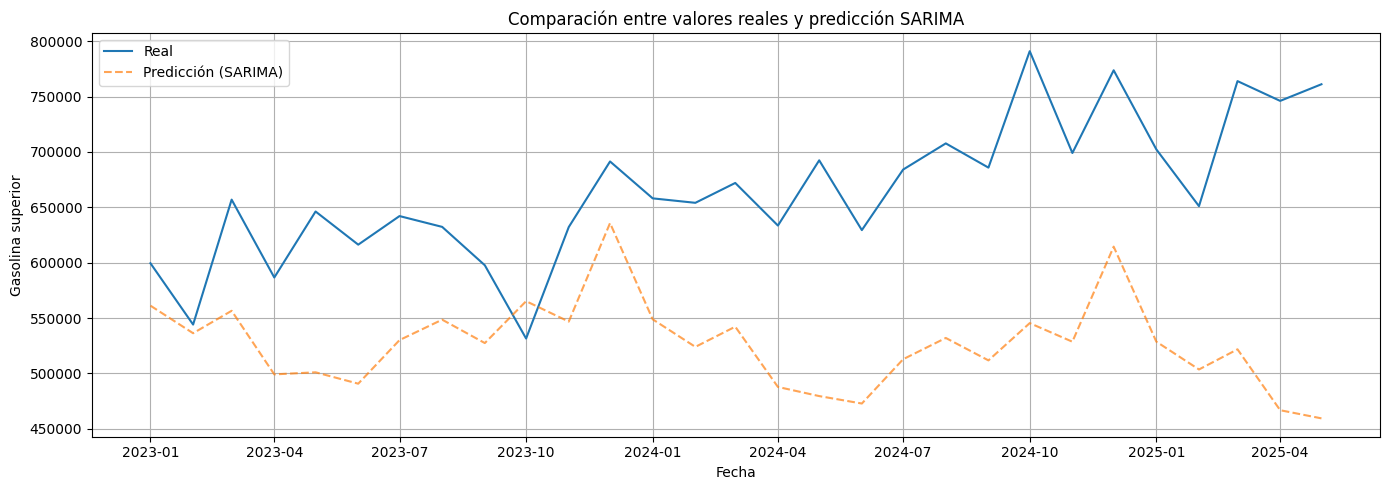

In [60]:
# Asegúrate de que el índice sea tipo datetime para graficar correctamente
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(comparison_df["Real"], label="Real")
plt.plot(comparison_df["Predicción (SARIMA)"], label="Predicción (SARIMA)", linestyle="--", alpha=0.7)
plt.title("Comparación entre valores reales y predicción SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Esto sugiere que el modelo no está capturando bien la magnitud o tendencia ascendente de la serie, lo cual es una señal clara de underfitting. Se puede obsvar como el modelo esta intentando capturar estacionalidad pero no lo logra. El modelo Sarima como esta ahorita no es el adecuado para poder predicir adecuadamente la tendencia. Se podria intentar suvizar el año 2020 porque ese el problema. Haciendo otras pruebas, si agrego el año 2023 a el train este captura de mejor forma la grafica y se asemeja un poco mas pero en la grafica de tendencia se puede observar como el pico final va hacia abajo y el modelo se queda con eso, si se le agrega el año 2023 el pico queda hacia arriba y el modelo por lo tanto sube para arriba.

## prophet 

In [31]:
from prophet import Prophet
import pandas as pd

df_prophet = train_data.reset_index().rename(columns={"Fecha": "ds", "Gasolina superior": "y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = pd.DataFrame(test_data.index)
future.columns = ['ds']
forecast = model_prophet.predict(future)

pred_prophet = forecast[['ds', 'yhat']].set_index("ds")["yhat"]


10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar modelo HW
hw_model = ExponentialSmoothing(train_data["Gasolina superior"], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

pred_hw = hw_fit.forecast(steps=len(test_data))
pred_hw.index = test_data.index  

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [36]:
# Normalizar la serie
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[["Gasolina superior"]])

# Función para crear dataset supervisado
def create_supervised(data, lag=12):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Configurar rezago
lag = 12
X_train, y_train = create_supervised(scaled_train, lag)

from sklearn.pipeline import Pipeline

# Definir el pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

# Hiperparámetros a evaluar
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001]
}

# Ejecutar GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid.fit(X_train, y_train)

# Mostrar el mejor modelo
print("Mejores hiperparámetros:", grid.best_params_)


# Predecir paso a paso para todo el período de test
last_input = scaled_train[-lag:].reshape(1, -1)
pred_scaled = []

best_model = grid.best_estimator_

for _ in range(len(test_data)):
    next_scaled = best_model.predict(last_input)[0]
    pred_scaled.append(next_scaled)
    last_input = np.append(last_input[:, 1:], [[next_scaled]], axis=1)

# Inversión del escalado
pred_mlp = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).flatten()
pred_mlp = pd.Series(pred_mlp, index=test_data.index)


comparison_df["MLP (Scikit-learn)"] = pred_mlp

# MAE del nuevo modelo
from sklearn.metrics import mean_absolute_error
print("MAE MLP (Scikit-learn):", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Scikit-learn)"]))



Mejores hiperparámetros: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__solver': 'adam'}
MAE MLP (Scikit-learn): 85825.41288468204


In [37]:
from sklearn.metrics import mean_absolute_error

comparison_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Prophet": pred_prophet,
    "Holt-Winters": pred_hw,
    "MLP (Neuronal)": pred_mlp
})

print(comparison_df)


print("MAE Prophet:", mean_absolute_error(comparison_df["Real"], comparison_df["Prophet"]))
print("MAE Holt-Winters:", mean_absolute_error(comparison_df["Real"], comparison_df["Holt-Winters"]))
print("MAE MLP:", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Neuronal)"]))


                 Real        Prophet   Holt-Winters  MLP (Neuronal)
2023-01-01  599501.29  627348.855358  561737.833805   608209.785106
2023-02-01  544144.00  611203.495912  551058.161260   600832.212616
2023-03-01  656941.64  638416.399638  587182.394918   642505.133407
2023-04-01  586642.20  615253.917915  558253.261722   630841.491039
2023-05-01  646221.20  610296.562505  570723.447026   552335.567972
2023-06-01  616290.21  598451.961472  564236.251816   549863.203299
2023-07-01  642098.16  632025.867066  597425.955671   577161.373164
2023-08-01  632333.40  630677.200308  604555.837282   575973.249989
2023-09-01  597670.26  609059.854459  574612.477809   551953.552465
2023-10-01  531542.58  642157.655979  602325.034933   562597.894843
2023-11-01  632180.03  628274.926755  584314.896482   571761.620940
2023-12-01  691389.62  686951.297622  657961.735523   598375.518879
2024-01-01  658083.66  641993.901176  582208.637696   578172.915799
2024-02-01  654059.60  622949.393978  571528.965

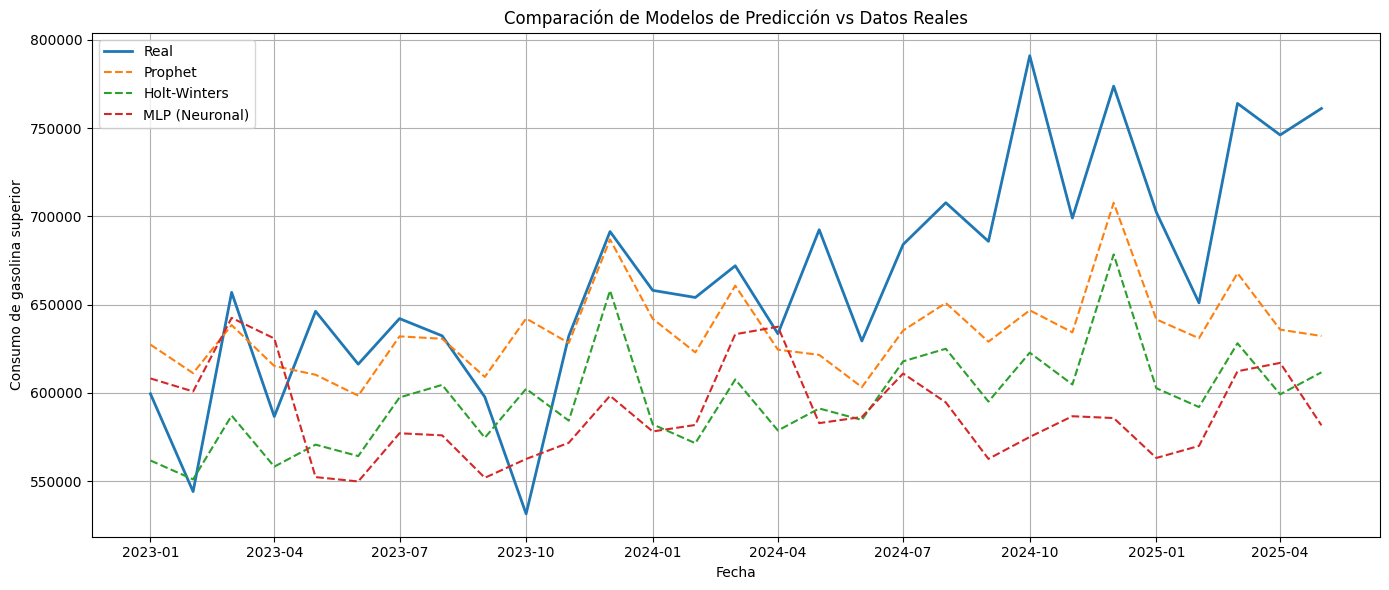

In [ ]:

# Asegurarte de que el índice sea de tipo datetime para una buena visualización
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 6))

plt.plot(comparison_df["Real"], label="Real", linewidth=2)
plt.plot(comparison_df["Prophet"], label="Prophet", linestyle="--")
plt.plot(comparison_df["Holt-Winters"], label="Holt-Winters", linestyle="--")
plt.plot(comparison_df["MLP (Neuronal)"], label="MLP (Neuronal)", linestyle="--")

plt.title("Comparación de Modelos de Predicción vs Datos Reales")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Comparando el resultado con SARIMA el que mejor logra capturar la tendncia siendo aceptable es el modelo de prophet que se aproxima a lo real , capturando pocos y un mejor balance. En cuanto a los otros en general se puede observar como tienen una mejor capturacion de datos que el modelo de SARIMA. Como mencione con anterioridad el año 2020 si es un golpe bastante fuerte para estos modelos desconcentrandolos y haciendo que aprendan de una mala forma.

# Consumo de Gas liquido

Como dijera suriano por tranquilidad nuestra vamos a volver a cargar los datos

In [63]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month



In [64]:
test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gas licuado de petróleo"]]

hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gas licuado de petróleo"]]


In [65]:
train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gas licuado de petróleo"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data

,Fecha,Gas licuado de petróleo,Año,Mes
0,2000-01-01,194410.476190,2000,1
1,2000-02-01,174710.552381,2000,2
2,2000-03-01,189234.066667,2000,3
3,2000-04-01,174330.607143,2000,4
4,2000-05-01,191745.147619,2000,5
...,...,...,...,...
271,2022-08-01,541273.940000,2022,8
272,2022-09-01,479529.680000,2022,9
273,2022-10-01,545823.450000,2022,10
274,2022-11-01,528393.770000,2022,11


In [66]:
train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

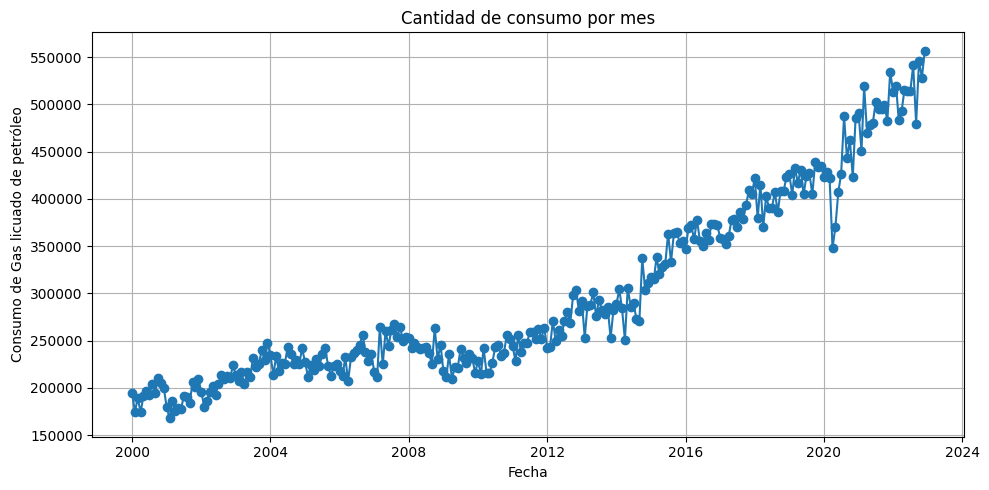

In [67]:

# Graficar solo la columna de consumo
plt.figure(figsize=(10, 5))
plt.plot(train_data["Gas licuado de petróleo"], marker='o')

plt.title("Cantidad de consumo por mes")
plt.xlabel("Fecha")
plt.ylabel("Consumo de Gas licuado de petróleo")
plt.grid(True)
plt.tight_layout()
plt.show()


# Agregar texto aqui xd

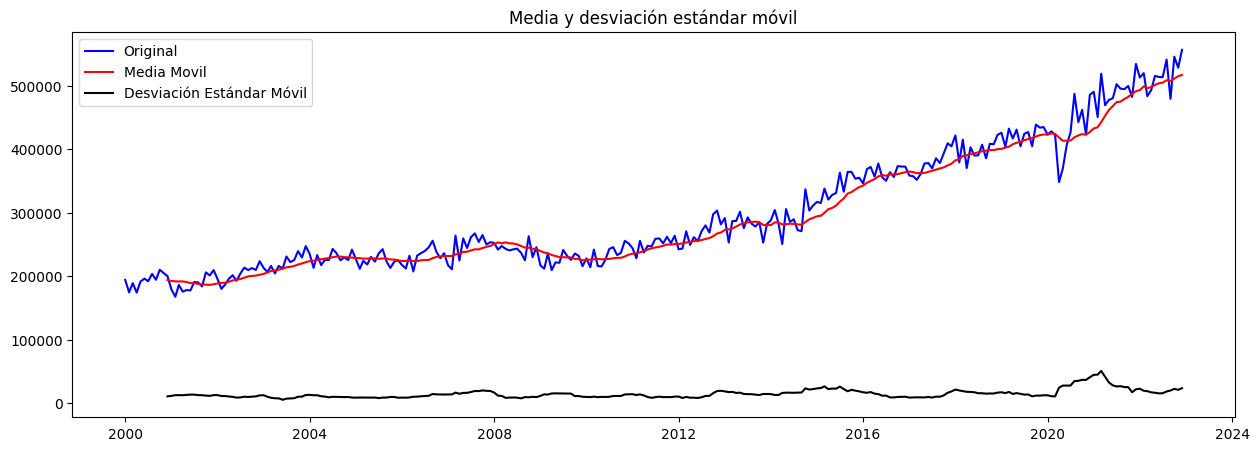

In [68]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = train_data["Gas licuado de petróleo"].rolling(window=12).mean()
deMovil = train_data["Gas licuado de petróleo"].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(train_data["Gas licuado de petróleo"], color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

# Agregar texto aqui 

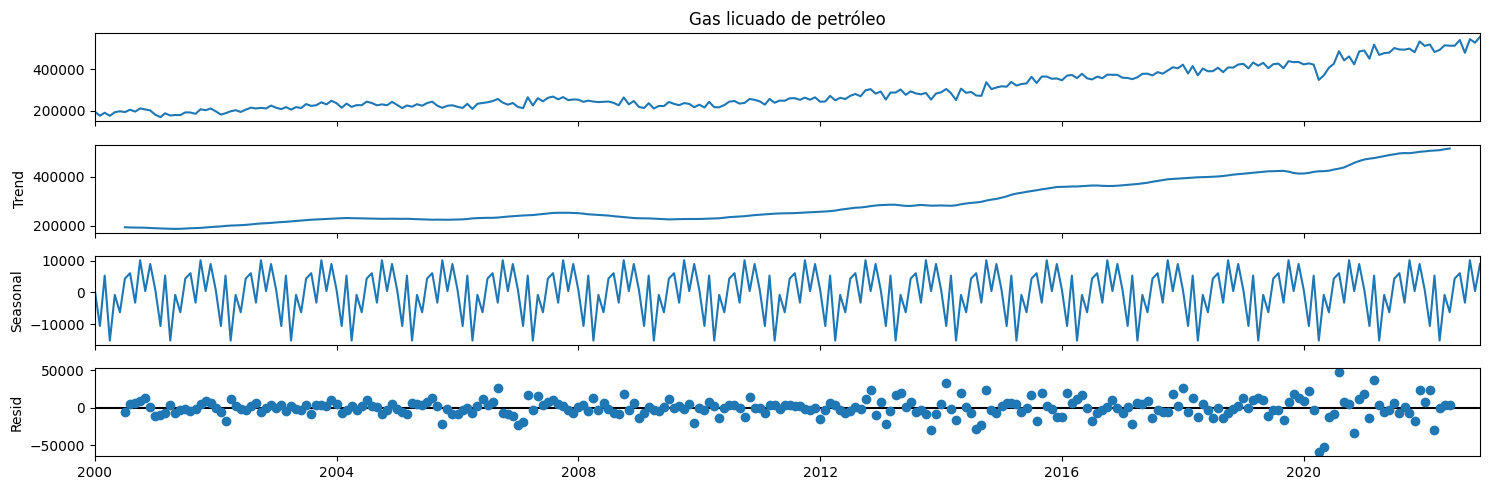

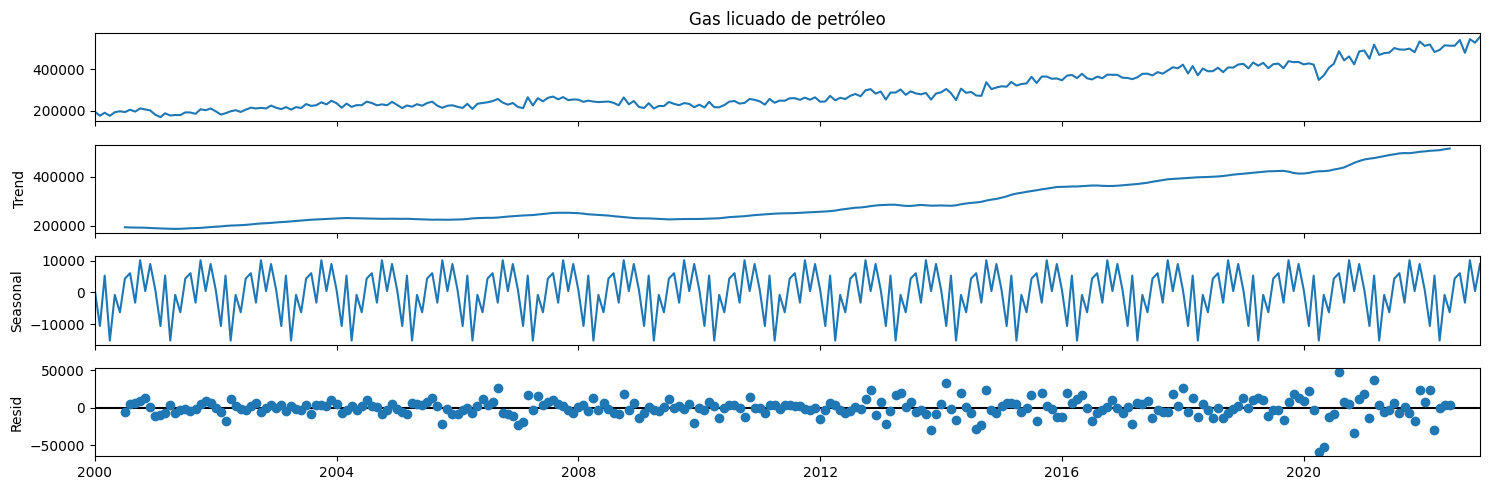

In [70]:
descomposicion = seasonal_decompose(train_data["Gas licuado de petróleo"])
descomposicion.plot()

Se puede observar como muestra una tendencia creciente constante. Se puede observar como existe una demanda sostenida y en aumento de gas licuado a lo largo de los años. Se puede observar como si existe una estacionalidad. La varianza de los residuos parece estable, lo que sugiere que el modelo de descomposición ha capturado correctamente la tendencia y la estacionalidad. A pesar de todo ese, se puede concluirq ue no es estacionaria media por la tendencia. No es tacionaria en varianza, porque la amplitur parace crecer levemente en los años.



In [72]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gas licuado de petróleo"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.641345
p-value                        0.999082
# de retardos usados          11.000000
# de observaciones usadas    264.000000
Critical Value (1%)           -3.455365
Critical Value (5%)           -2.872551
Critical Value (10%)          -2.572638
dtype: float64


Se puede observar como el valor de p es bastante alto mayor a 0.05 por lo tanto la hipotesis nula no es estacionaria en media. Aplicamos diferenciacion y logaritmo para ver si alguna hace que se vuelva estacionaria

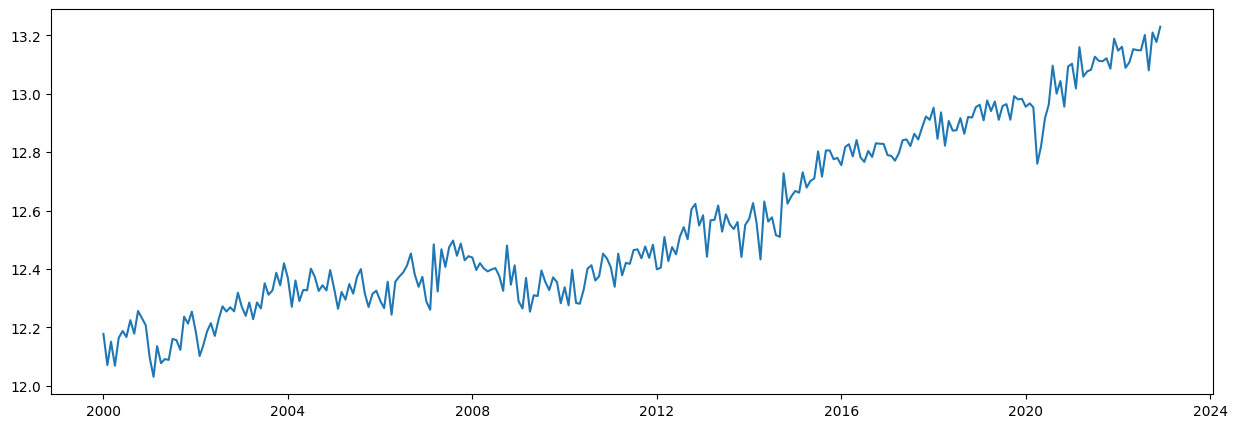

In [74]:
ts_air_pas_log = np.log(train_data["Gas licuado de petróleo"])
plt.plot(ts_air_pas_log)

In [75]:

# Aplicar logaritmo
ts_log = np.log(train_data["Gas licuado de petróleo"])

# Hacer el test ADF sobre la serie logarítmica directamente
adf_log = adfuller(ts_log.dropna())
print("ADF - Logarítmica")
print(pd.Series(adf_log[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas']))


ADF - Logarítmica
Estadístico de prueba          0.547870
p-value                        0.986258
# de retardos usados          14.000000
# de observaciones usadas    261.000000
dtype: float64


No

In [77]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gas licuado de petróleo"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.441399
p-value                        0.009626
# de retardos usados          16.000000
# de observaciones usadas    258.000000
Critical Value (1%)           -3.455953
Critical Value (5%)           -2.872809
Critical Value (10%)          -2.572775
dtype: float64


con una diferencia es estacionaria en media

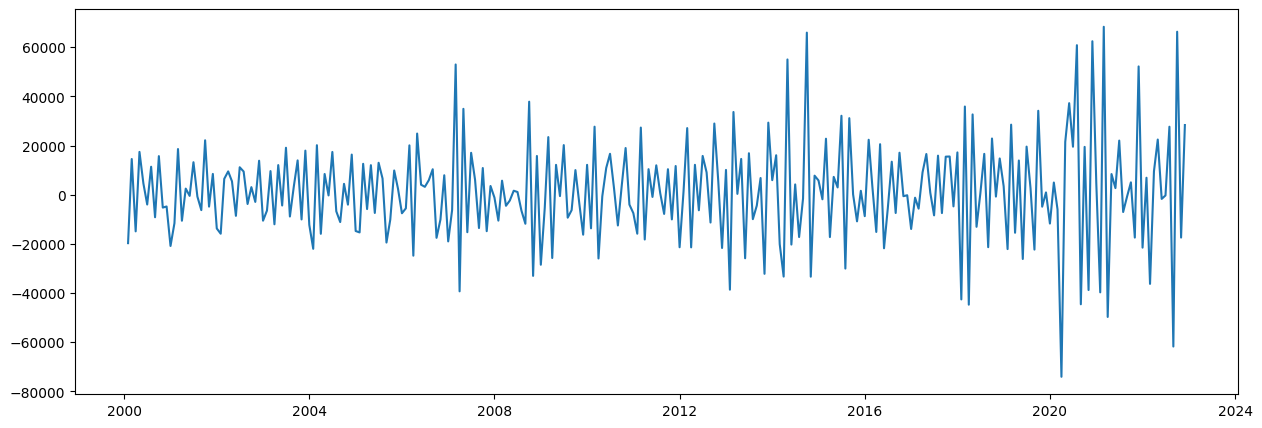

In [78]:
plt.plot(ts_air_pas_diff)

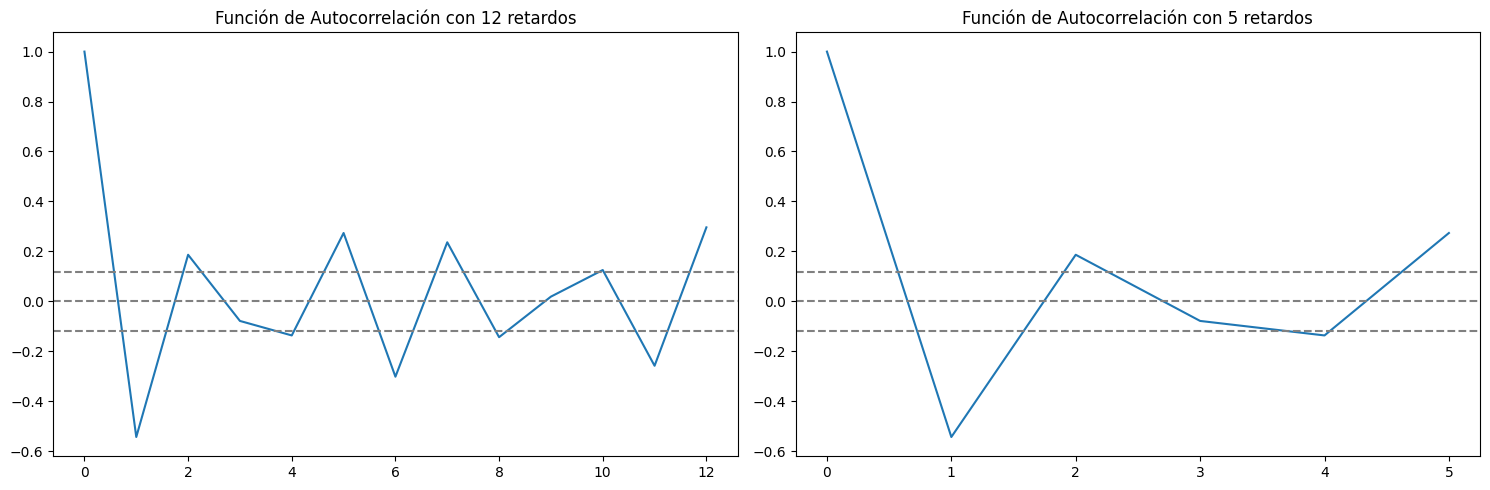

In [79]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_air_pas_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_air_pas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

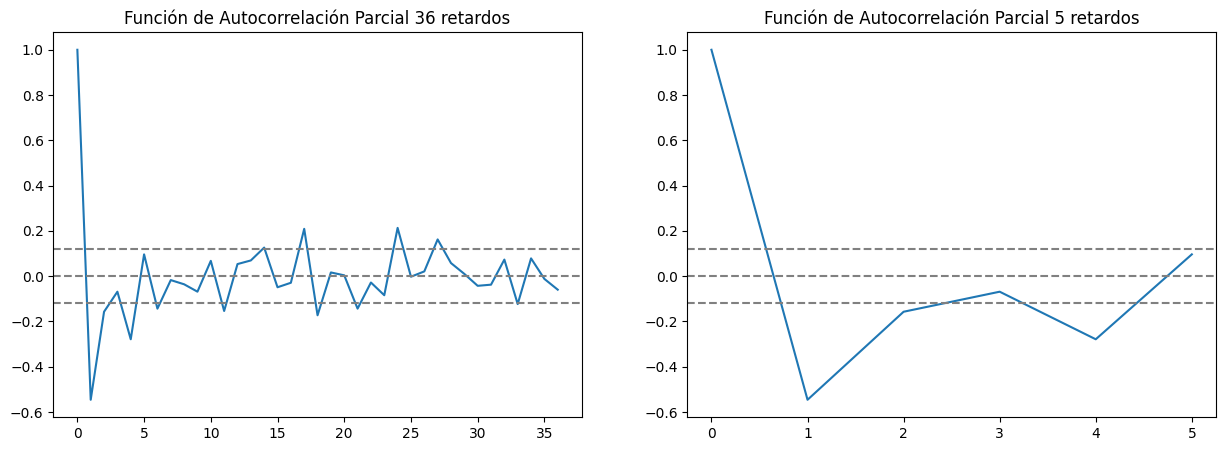

In [80]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_air_pas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_air_pas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

p = 1, q = 1. p = 2, q = 2 y d = 1

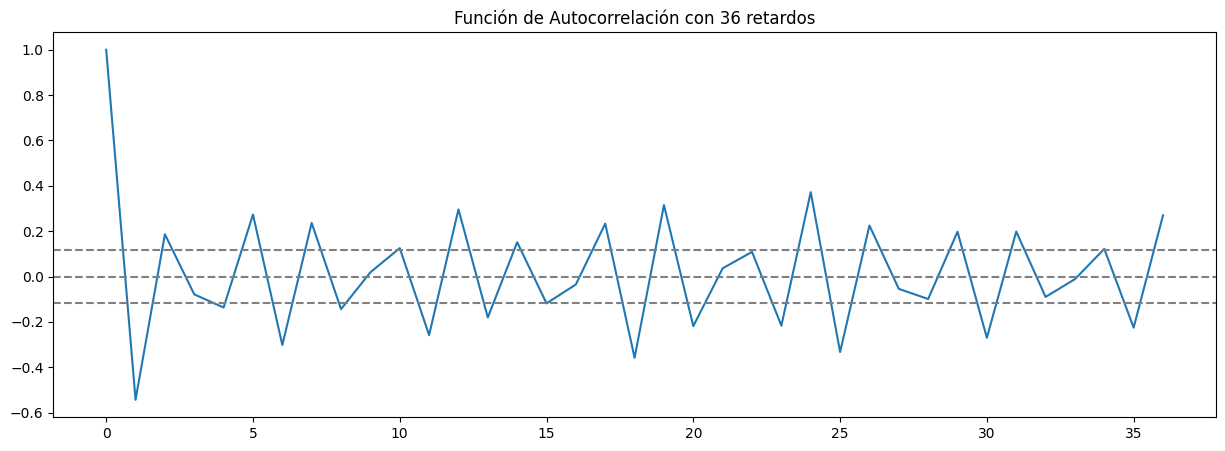

In [82]:
plt.plot(acf(ts_air_pas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Es estacionaria en 12 meses

In [83]:
ts_air_pas_diff_D = ts_air_pas_diff.diff(12)
ts_air_pas_diff_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

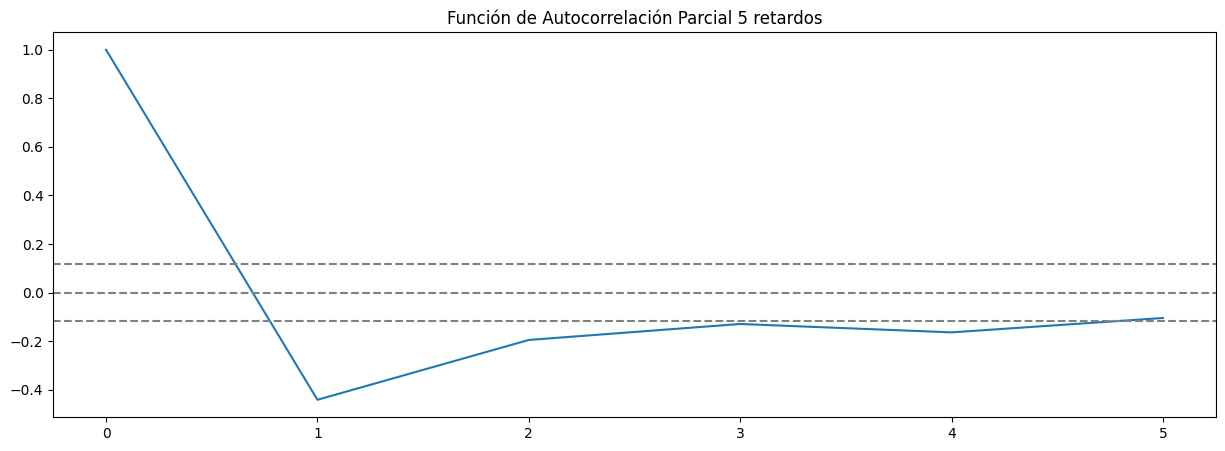

In [84]:
plt.plot(pacf(ts_air_pas_diff_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


In [85]:
modelo_sarima = SARIMAX(
    ts_air_pas_diff,
    order=(1, 1, 1),                 # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 12),    # SARIMA(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_sarima.fit()

print(resultado_sarima.summary().tables[1])

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4333      0.121     -3.584      0.000      -0.670      -0.196
ma.L1         -0.9724      0.041    -23.447      0.000      -1.054      -0.891
ar.S.L12      -0.1089      0.186     -0.586      0.558      -0.473       0.255
ma.S.L12      -0.8097      0.139     -5.809      0.000      -1.083      -0.536
sigma2      6.609e+08   1.16e-10    5.7e+18      0.000    6.61e+08    6.61e+08


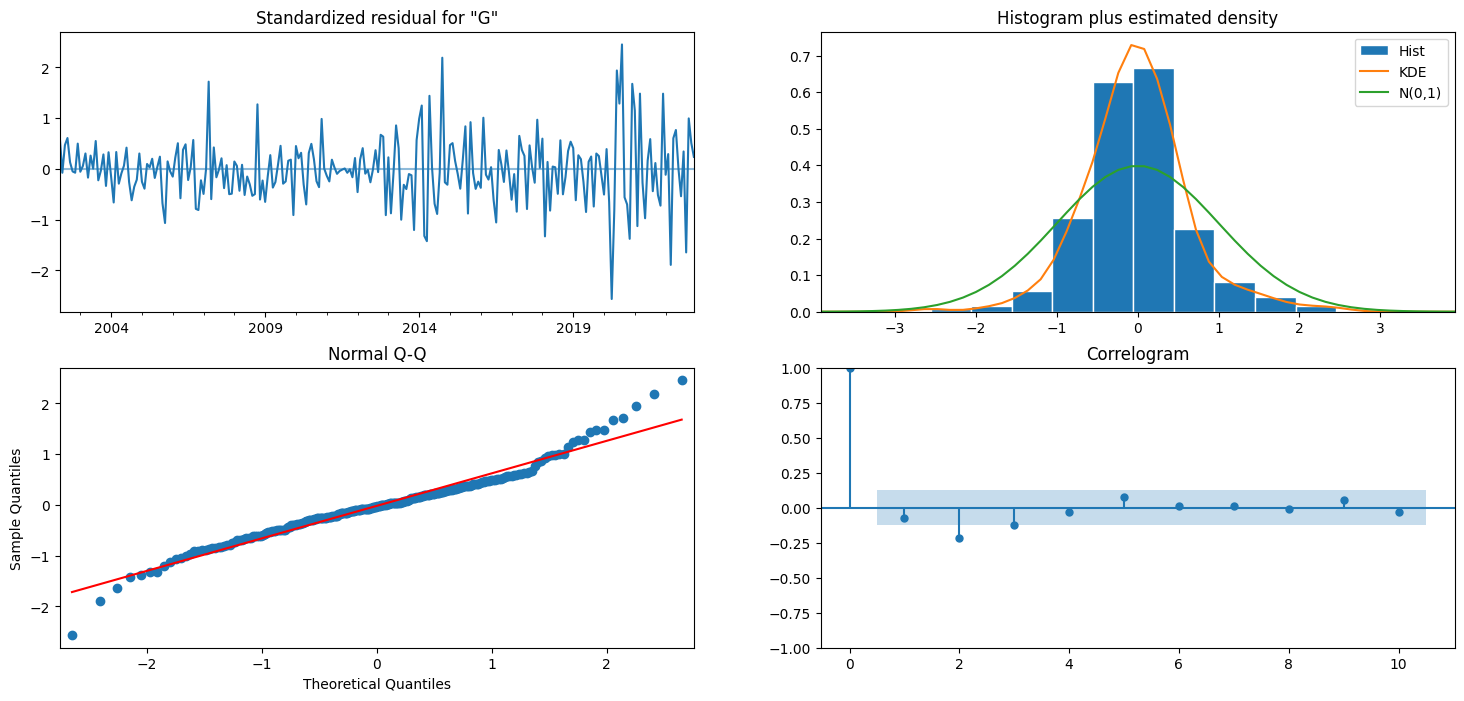

In [86]:
resultado_sarima.plot_diagnostics(figsize=(18, 8))
plt.show()

In [87]:
modelo_2 = SARIMAX(
    ts_air_pas_diff,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_2 = modelo_2.fit()
print("Modelo SARIMA(2,1,0)(1,1,1,12)")
print(resultado_2.summary().tables[1])

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMA(2,1,0)(1,1,1,12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1148      0.187      0.615      0.539      -0.251       0.481
ar.L2          0.0402      0.158      0.254      0.800      -0.270       0.350
ma.L1         -1.6554      0.181     -9.162      0.000      -2.010      -1.301
ma.L2          0.6851      0.184      3.731      0.000       0.325       1.045
ar.S.L12      -0.1589      0.166     -0.955      0.340      -0.485       0.167
ma.S.L12      -0.7942      0.128     -6.195      0.000      -1.045      -0.543
sigma2      5.346e+08    3.9e-10   1.37e+18      0.000    5.35e+08    5.35e+08


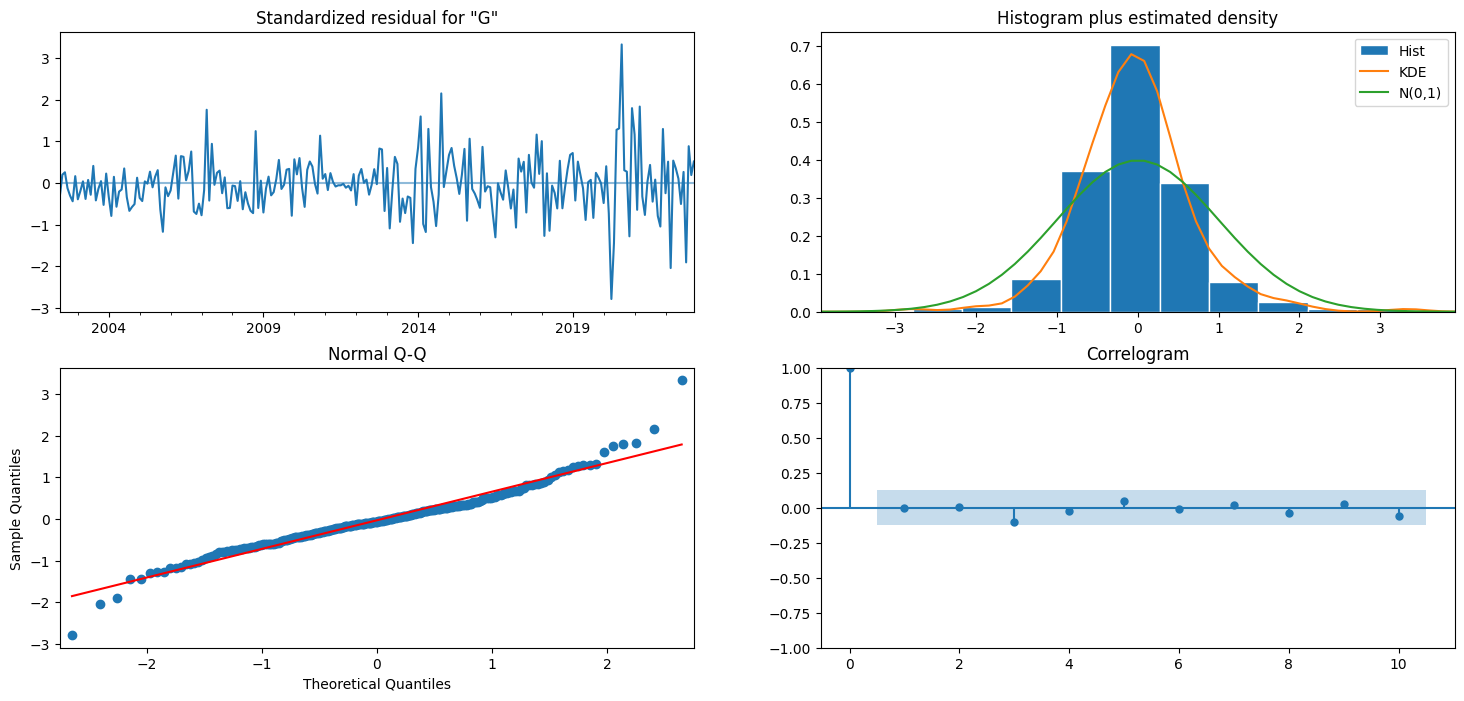

In [88]:
resultado_2.plot_diagnostics(figsize=(18, 8))
plt.show()

In [89]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1=",resultado_sarima.aic)
print("Modelo 2=",resultado_2.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1=",resultado_sarima.bic)
print("Modelo 2=",resultado_2.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1= 5606.220853145793
Modelo 2= 5549.758167590206
Resultados de BIC (Bayesian information criterion)
Modelo 1= 5623.787996876617
Modelo 2= 5574.323885946602


In [90]:
hoja_df_2025 = pd.read_excel("./data/VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gas licuado de petróleo"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)

In [91]:
test_data.index[0]


Timestamp('2023-01-01 00:00:00')

In [93]:
# Obtener predicciones desde el modelo
pred = resultado_2.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_diff = pred.predicted_mean

# Reconstruir valores originales sumando las diferencias al último valor conocido del train
last_train_value = train_data["Gas licuado de petróleo"].iloc[-1]
predicted_real = pred_diff.cumsum() + last_train_value


In [95]:
comparison_df = pd.DataFrame({
    "Real": test_data["Gas licuado de petróleo"],
    "Predicción (SARIMA)": predicted_real
})
comparison_df

,Real,Predicción (SARIMA)
2023-01-01,574148.00,548722.168406
2023-02-01,497273.19,535400.611562
2023-03-01,588892.16,557927.930677
2023-04-01,513919.89,527260.580043
2023-05-01,561767.17,546137.059824
2023-06-01,532138.90,546156.945530
2023-07-01,521833.56,559966.894287
2023-08-01,543825.64,572332.329346
2023-09-01,517699.48,557959.697174
2023-10-01,495261.14,579338.676300


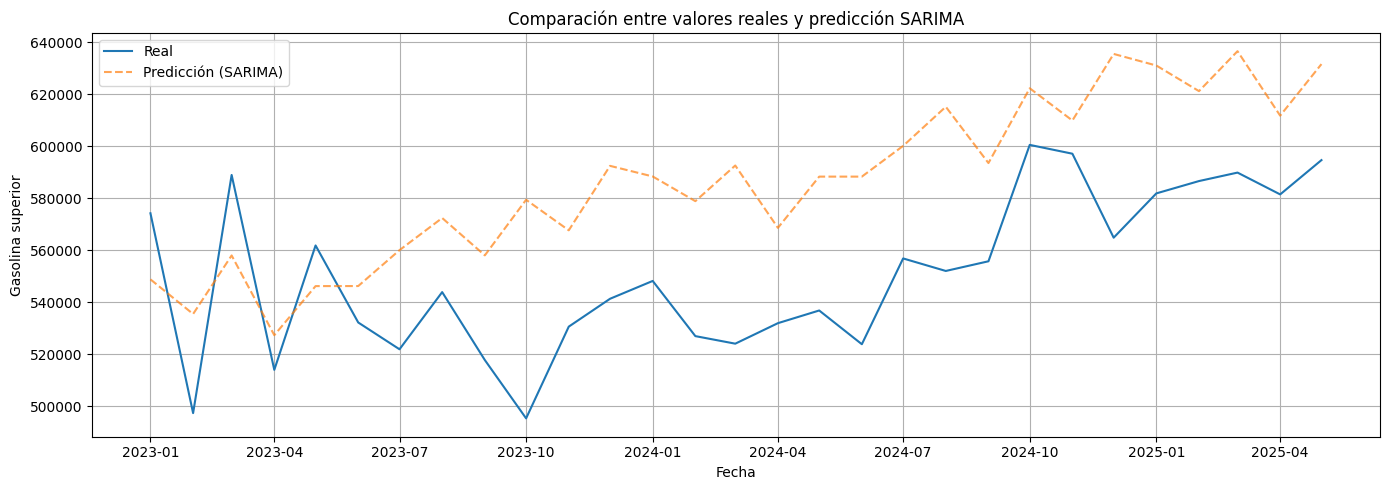

In [ ]:
# Asegúrate de que el índice sea tipo datetime para graficar correctamente
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(comparison_df["Real"], label="Real")
plt.plot(comparison_df["Predicción (SARIMA)"], label="Predicción (SARIMA)", linestyle="--", alpha=0.7)
plt.title("Comparación entre valores reales y predicción SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Gas licuado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


La predicción mantiene una tendencia creciente, pero tiende a sobreestimar los valores reales consistentemente, especialmente hacia el final del horizonte de predicción.No capta bien los picos y valles (variabilidad mensual), por lo que parece muy suavizado.

# otros

In [97]:
from prophet import Prophet
import pandas as pd

df_prophet = train_data.reset_index().rename(columns={"Fecha": "ds", "Gas licuado de petróleo": "y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = pd.DataFrame(test_data.index)
future.columns = ['ds']
forecast = model_prophet.predict(future)

pred_prophet = forecast[['ds', 'yhat']].set_index("ds")["yhat"]


11:14:02 - cmdstanpy - INFO - Chain [1] start processing
11:14:03 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar modelo HW
hw_model = ExponentialSmoothing(train_data["Gas licuado de petróleo"], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

pred_hw = hw_fit.forecast(steps=len(test_data))
pred_hw.index = test_data.index  

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [99]:
# Normalizar la serie
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[["Gas licuado de petróleo"]])

# Función para crear dataset supervisado
def create_supervised(data, lag=12):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Configurar rezago
lag = 12
X_train, y_train = create_supervised(scaled_train, lag)

from sklearn.pipeline import Pipeline

# Definir el pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

# Hiperparámetros a evaluar
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001]
}

# Ejecutar GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid.fit(X_train, y_train)

# Mostrar el mejor modelo
print("Mejores hiperparámetros:", grid.best_params_)


# Predecir paso a paso para todo el período de test
last_input = scaled_train[-lag:].reshape(1, -1)
pred_scaled = []

best_model = grid.best_estimator_

for _ in range(len(test_data)):
    next_scaled = best_model.predict(last_input)[0]
    pred_scaled.append(next_scaled)
    last_input = np.append(last_input[:, 1:], [[next_scaled]], axis=1)

# Inversión del escalado
pred_mlp = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).flatten()
pred_mlp = pd.Series(pred_mlp, index=test_data.index)


comparison_df["MLP (Scikit-learn)"] = pred_mlp

# MAE del nuevo modelo
from sklearn.metrics import mean_absolute_error
print("MAE MLP (Scikit-learn):", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Scikit-learn)"]))



Mejores hiperparámetros: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__solver': 'adam'}
MAE MLP (Scikit-learn): 22976.645194782937


In [101]:
from sklearn.metrics import mean_absolute_error

comparison_df = pd.DataFrame({
    "Real": test_data["Gas licuado de petróleo"],
    "Prophet": pred_prophet,
    "Holt-Winters": pred_hw,
    "MLP (Neuronal)": pred_mlp
})

print(comparison_df)


print("MAE Prophet:", mean_absolute_error(comparison_df["Real"], comparison_df["Prophet"]))
print("MAE Holt-Winters:", mean_absolute_error(comparison_df["Real"], comparison_df["Holt-Winters"]))
print("MAE MLP:", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Neuronal)"]))


                 Real        Prophet   Holt-Winters  MLP (Neuronal)
2023-01-01  574148.00  520198.104595  539061.795980   547807.918034
2023-02-01  497273.19  512593.405206  527514.443263   546863.826458
2023-03-01  588892.16  526631.803517  542683.011943   532510.877395
2023-04-01  513919.89  510240.190228  525501.064654   525902.487436
2023-05-01  561767.17  530700.276397  542990.267993   534305.085015
2023-06-01  532138.90  522935.213938  540426.786711   538823.407648
2023-07-01  521833.56  540019.564274  552541.424550   531699.552875
2023-08-01  543825.64  537777.598271  559124.719157   554465.300907
2023-09-01  517699.48  533708.274568  548461.634860   514209.192300
2023-10-01  495261.14  550948.278564  569593.680641   544021.975944
2023-11-01  530542.42  543814.176827  561285.068154   543105.191701
2023-12-01  541263.18  552939.818149  574836.061347   550574.863804
2024-01-01  548124.45  544970.082121  567399.688907   557294.585310
2024-02-01  526897.85  541043.342188  555852.336

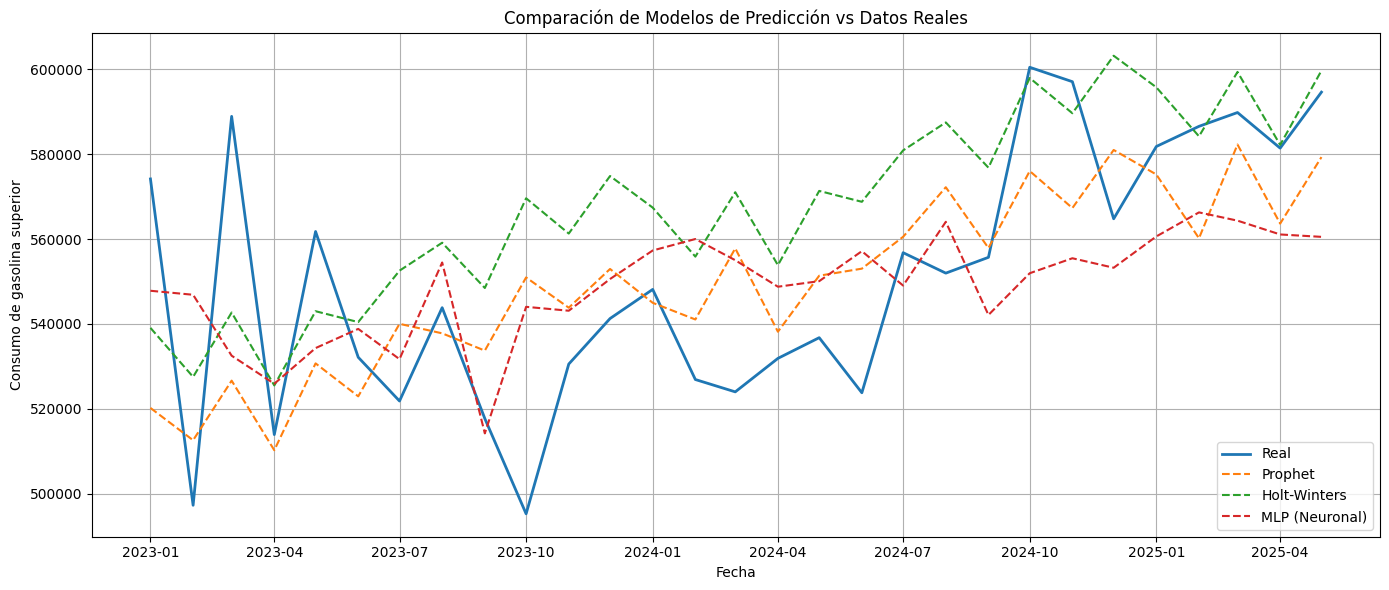

In [102]:

# Asegurarte de que el índice sea de tipo datetime para una buena visualización
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 6))

plt.plot(comparison_df["Real"], label="Real", linewidth=2)
plt.plot(comparison_df["Prophet"], label="Prophet", linestyle="--")
plt.plot(comparison_df["Holt-Winters"], label="Holt-Winters", linestyle="--")
plt.plot(comparison_df["MLP (Neuronal)"], label="MLP (Neuronal)", linestyle="--")

plt.title("Comparación de Modelos de Predicción vs Datos Reales")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Prophet: Captura mejor los patrones estacionales y muestra una evolución similar a la serie real, aunque también suaviza un poco.

Holt-Winters: Es el que más se alinea visualmente con la tendencia y variación de los datos reales. Captura los ascensos y descensos más parecidos a la serie real.

Red neuronal: Tiene una respuesta más segmentada y brusca. Aunque mejora sobre algunos puntos, tiende a subestimar valores altos y no refleja bien la estacionalidad.